<a href="https://colab.research.google.com/github/kapoorkhushi03/3d-portfolio/blob/main/Copy_of_Finalstep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, array_to_img

# Paths to your dataset
train_human_images_path = '/content/drive/MyDrive/Classroom/DATASET/Train/Agnostic V3.2'
train_top_masks_path = '/content/drive/MyDrive/Classroom/DATASET/Train/Clothmask'
train_tops_path = '/content/drive/MyDrive/Classroom/DATASET/Train/Cloth'

val_human_images_path = '/content/drive/MyDrive/Classroom/DATASET/Val/Agnostic V3.2'
val_top_masks_path = '/content/drive/MyDrive/Classroom/DATASET/Val/Clothmask'
val_tops_path = '/content/drive/MyDrive/Classroom/DATASET/Val/Cloth'

test_human_images_path = '/content/drive/MyDrive/Classroom/DATASET/Test/Agnostic V3.2'
test_top_masks_path = '/content/drive/MyDrive/Classroom/DATASET/Test/Clothmask'
test_tops_path = '/content/drive/MyDrive/Classroom/DATASET/Test/Cloth'


In [ ]:
def load_images_from_folder(folder, size=(256, 256), grayscale=False):
    images = []
    for filename in os.listdir(folder):
        if grayscale:
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img)
    return np.array(images)

# Load images
train_human_images = load_images_from_folder(train_human_images_path)
train_top_masks = load_images_from_folder(train_top_masks_path, size=(256, 256), grayscale=True)
train_tops = load_images_from_folder(train_tops_path, size=(256, 256), grayscale=True)

val_human_images = load_images_from_folder(val_human_images_path)
val_top_masks = load_images_from_folder(val_top_masks_path, size=(256, 256), grayscale=True)
val_tops = load_images_from_folder(val_tops_path, size=(256, 256), grayscale=True)

test_human_images = load_images_from_folder(test_human_images_path)
test_top_masks = load_images_from_folder(test_top_masks_path, size=(256, 256), grayscale=True)
test_tops = load_images_from_folder(test_tops_path, size=(256, 256), grayscale=True)

# Normalize the images and masks
train_human_images = train_human_images / 255.0
train_top_masks = train_top_masks / 255.0
train_tops = train_tops / 255.0

val_human_images = val_human_images / 255.0
val_top_masks = val_top_masks / 255.0
val_tops = val_tops / 255.0

test_human_images = test_human_images / 255.0
test_top_masks = test_top_masks / 255.0
test_tops = test_tops / 255.0

# Ensure masks are binary
train_top_masks = (train_top_masks > 0.5).astype(np.float32)
val_top_masks = (val_top_masks > 0.5).astype(np.float32)
test_top_masks = (test_top_masks > 0.5).astype(np.float32)

# Add a channel dimension to the masks (for binary masks, this is necessary for the loss function)
train_top_masks = np.expand_dims(train_top_masks, axis=-1)
val_top_masks = np.expand_dims(val_top_masks, axis=-1)
test_top_masks = np.expand_dims(test_top_masks, axis=-1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.models import Model

def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Down-sampling
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Up-sampling
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:


history = model.fit(train_human_images, train_top_masks, batch_size=8, epochs=50, validation_data=(val_human_images, val_top_masks))


Epoch 1/50
13/13 [==============================] - 55s 2s/step - loss: 1.4366 - accuracy: 0.5510 - val_loss: 0.6735 - val_accuracy: 0.5351
Epoch 2/50
13/13 [==============================] - 6s 464ms/step - loss: 0.6615 - accuracy: 0.5568 - val_loss: 0.9304 - val_accuracy: 0.5351
Epoch 3/50
13/13 [==============================] - 6s 467ms/step - loss: 0.6700 - accuracy: 0.5561 - val_loss: 0.6172 - val_accuracy: 0.5302
Epoch 4/50
13/13 [==============================] - 6s 469ms/step - loss: 0.6565 - accuracy: 0.5731 - val_loss: 0.6167 - val_accuracy: 0.5427
Epoch 5/50
13/13 [==============================] - 6s 472ms/step - loss: 0.6181 - accuracy: 0.6859 - val_loss: 0.5068 - val_accuracy: 0.8239
Epoch 6/50
13/13 [==============================] - 6s 499ms/step - loss: 0.5013 - accuracy: 0.7769 - val_loss: 0.3708 - val_accuracy: 0.8448
Epoch 7/50
13/13 [==============================] - 6s 477ms/step - loss: 0.4318 - accuracy: 0.8172 - val_loss: 0.3355 - val_accuracy: 0.8545
Epoch 8/

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_human_images, test_top_masks)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


1/1 [==============================] - 17s 17s/step - loss: 0.3104 - accuracy: 0.8549
Test Loss: 0.3104, Test Accuracy: 0.8549


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
human_image = cv2.imread('/mnt/data/human_image.jpg')
top_mask = cv2.imread('/mnt/data/top_mask.jpg', cv2.IMREAD_GRAYSCALE)
predicted_mask = cv2.imread('/mnt/data/predicted_mask.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images loaded successfully
if human_image is None:
    print("Error: Could not load human image. Check the file path.")
if top_mask is None:
    print("Error: Could not load top mask. Check the file path.")
if predicted_mask is None:
    print("Error: Could not load predicted mask. Check the file path.")

# Assuming human_image and top_mask are color images, and predicted_mask is grayscale
# You need to resize masks if they do not match the size of human_image
if human_image is not None and top_mask is not None and predicted_mask is not None:
    top_mask = cv2.resize(top_mask, (human_image.shape[1], human_image.shape[0]))
    predicted_mask = cv2.resize(predicted_mask, (human_image.shape[1], human_image.shape[0]))

# Extract the contours from the top mask
contours, _ = cv2.findContours(top_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Choose the largest contour which will likely be the clothing
contour = max(contours, key=cv2.contourArea)

# Get the bounding box of the contour
x, y, w, h = cv2.boundingRect(contour)

# Create a perspective transformation matrix based on the bounding box
src_pts = np.float32([[x, y], [x+w, y], [x, y+h], [x+w, y+h]])
dst_pts = np.float32([[x, y], [x+w, y], [x, y+h], [x+w, y+h]])
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# Warp the top mask
warped_top = cv2.warpPerspective(top_mask, M, (human_image.shape[1], human_image.shape[0]))

# Convert masks to boolean
predicted_mask = predicted_mask.astype(bool)
warped_top = warped_top.astype(bool)

# Create a colored top (using original top image color or a fixed color)
colored_top = np.zeros_like(human_image)
colored_top[:, :] = [0, 0, 255]  # Example color: Red

# Apply the predicted mask to the colored top
colored_top_masked = np.where(predicted_mask[..., None], colored_top, 0)

# Integrate the warped top with the human image
combined_image = np.where(predicted_mask[..., None], colored_top_masked, human_image)

# Display the result
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Human Image')
plt.imshow(cv2.cvtColor(human_image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Combined Image')
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
plt.show()


Error: Could not load human image. Check the file path.
Error: Could not load top mask. Check the file path.
Error: Could not load predicted mask. Check the file path.


ValueError: max() arg is an empty sequence

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
human_image = cv2.imread('/mnt/data/human_image.jpg')
top_mask = cv2.imread('/mnt/data/top_mask.jpg', cv2.IMREAD_GRAYSCALE)
predicted_mask = cv2.imread('/mnt/data/predicted_mask.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images loaded successfully
if human_image is None:
    print("Error: Could not load human image. Check the file path.")
if top_mask is None:
    print("Error: Could not load top mask. Check the file path.")
if predicted_mask is None:
    print("Error: Could not load predicted mask. Check the file path.")

if human_image is not None and top_mask is not None and predicted_mask is not None:
    print("Human Image Shape:", human_image.shape)
    print("Top Mask Shape:", top_mask.shape)
    print("Predicted Mask Shape:", predicted_mask.shape)

    # Assuming human_image and top_mask are color images, and predicted_mask is grayscale
    # You need to resize masks if they do not match the size of human_image
    top_mask = cv2.resize(top_mask, (human_image.shape[1], human_image.shape[0]))
    predicted_mask = cv2.resize(predicted_mask, (human_image.shape[1], human_image.shape[0]))

    # Extract the contours from the top mask
    contours, _ = cv2.findContours(top_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("Error: No contours found in the top mask.")
    else:
        # Choose the largest contour which will likely be the clothing
        contour = max(contours, key=cv2.contourArea)

        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Create a perspective transformation matrix based on the bounding box
        src_pts = np.float32([[x, y], [x+w, y], [x, y+h], [x+w, y+h]])
        dst_pts = np.float32([[x, y], [x+w, y], [x, y+h], [x+w, y+h]])
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)

        # Warp the top mask
        warped_top = cv2.warpPerspective(top_mask, M, (human_image.shape[1], human_image.shape[0]))

        # Convert masks to boolean
        predicted_mask = predicted_mask.astype(bool)
        warped_top = warped_top.astype(bool)

        # Create a colored top (using original top image color or a fixed color)
        colored_top = np.zeros_like(human_image)
        colored_top[:, :] = [0, 0, 255]  # Example color: Red

        # Apply the predicted mask to the colored top
        colored_top_masked = np.where(predicted_mask[..., None], colored_top, 0)

        # Integrate the warped top with the human image
        combined_image = np.where(predicted_mask[..., None], colored_top_masked, human_image)

        # Display the result
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title('Human Image')


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
human_image = cv2.imread('/mnt/data/human_image.jpg')
top_mask = cv2.imread('/mnt/data/top_mask.jpg', cv2.IMREAD_GRAYSCALE)
predicted_mask = cv2.imread('/mnt/data/predicted_mask.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images loaded successfully
if human_image is None:
    print("Error: Could not load human image. Check the file path.")
if top_mask is None:
    print("Error: Could not load top mask. Check the file path.")
if predicted_mask is None:
    print("Error: Could not load predicted mask. Check the file path.")

# Assuming human_image and top_mask are color images, and predicted_mask is grayscale
# You need to resize masks if they do not match the size of human_image
if human_image is not None and top_mask is not None and predicted_mask is not None:
    top_mask = cv2.resize(top_mask, (human_image.shape[1], human_image.shape[0]))
    predicted_mask = cv2.resize(predicted_mask, (human_image.shape[1], human_image.shape[0]))

In [ ]:
import matplotlib.pyplot as plt

def overlay_top(human_image, top_mask, top_image):
    # Resize top_mask to match the size of the human_image
    top_mask_resized = cv2.resize(top_mask, (human_image.shape[1], human_image.shape[0]))

    # Threshold the mask to create a binary mask
    _, top_mask_binary = cv2.threshold(top_mask_resized, 0.5, 1.0, cv2.THRESH_BINARY)

    # Resize the top_image to match the human_image dimensions
    top_image_resized = cv2.resize(top_image, (human_image.shape[1], human_image.shape[0]))

    # Apply the mask to the top image
    top_image_masked = top_image_resized * top_mask_binary[..., None]

    # Combine the human image with the masked top image
    combined_image = human_image.copy()
    combined_image[top_mask_binary == 1.0] = top_image_masked[top_mask_binary == 1.0]

    return combined_image

# Predict masks for test images
predicted_masks = model.predict(test_human_images)

# Choose a sample for visualization
sample_index = 0
human_image = test_human_images[sample_index]
top_mask = test_top_masks[sample_index]
top_image = test_tops[sample_index]

# Get the predicted mask
predicted_mask = predicted_masks[sample_index]

# Overlay the top image on the human image
combined_image = overlay_top(human_image, top_mask, top_image)

# Display the results
plt.figure(figsize=(12, 8))

plt.subplot(1, 4, 1)
plt.title('Human Image')
plt.imshow(human_image)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Top Mask')
plt.imshow(top_mask.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Predicted Mask')
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Combined Image')
plt.imshow(combined_image)
plt.axis('off')

plt.tight_layout()
plt.show()



Human Image Shape: (1024, 768, 3)
Cloth Image Shape: (1024, 768, 3)
Cloth Mask Shape: (1024, 768)
Predicted mask saved to /mnt/data/output/predicted_mask.png
Combined image saved to /mnt/data/output/combined_image.png


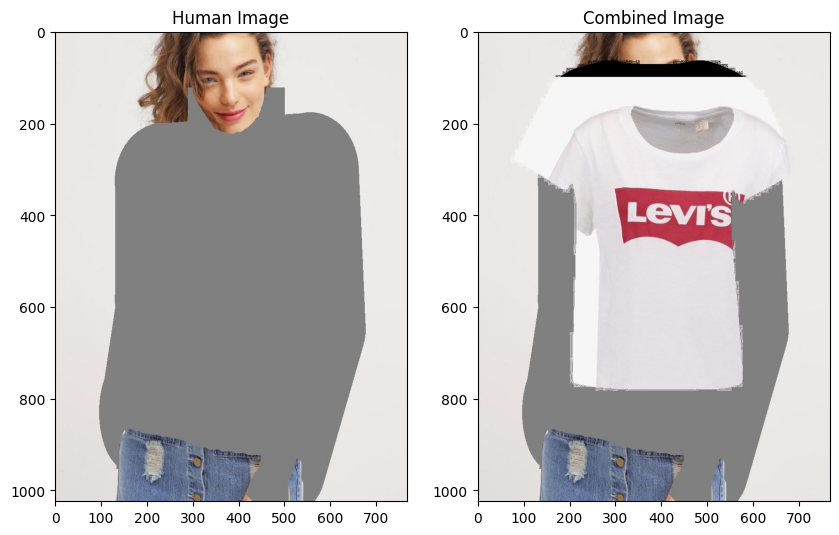

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths
output_dir = '/mnt/data/output/'
os.makedirs(output_dir, exist_ok=True)

# Load images
human_image = cv2.imread('/content/drive/MyDrive/Classroom/DATASET/Train/Agnostic V3.2/00000_00.jpg')
cloth_image = cv2.imread('/content/drive/MyDrive/Classroom/DATASET/Train/Cloth/00000_00.jpg')  # Load your cloth image here
cloth_mask = cv2.imread('/content/drive/MyDrive/Classroom/DATASET/Train/Clothmask/00000_00.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images loaded successfully
if human_image is None:
    print("Error: Could not load human image. Check the file path.")
if cloth_image is None:
    print("Error: Could not load cloth image. Check the file path.")
if cloth_mask is None:
    print("Error: Could not load cloth mask. Check the file path.")

if human_image is not None and cloth_image is not None and cloth_mask is not None:
    print("Human Image Shape:", human_image.shape)
    print("Cloth Image Shape:", cloth_image.shape)
    print("Cloth Mask Shape:", cloth_mask.shape)

    # Resize cloth mask and cloth image to match the human image size
    cloth_mask = cv2.resize(cloth_mask, (human_image.shape[1], human_image.shape[0]))
    cloth_image = cv2.resize(cloth_image, (human_image.shape[1], human_image.shape[0]))

    # Extract the contours from the cloth mask
    contours, _ = cv2.findContours(cloth_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("Error: No contours found in the cloth mask.")
    else:
        # Choose the largest contour which will likely be the clothing
        contour = max(contours, key=cv2.contourArea)

        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Adjust the destination points to better position the clothing on the human image
        # These values might need to be tweaked based on your specific images
        offset_x = 50  # Example offset for x-axis
        offset_y = 100  # Example offset for y-axis

        src_pts = np.float32([[x, y], [x+w, y], [x, y+h], [x+w, y+h]])
        dst_pts = np.float32([[x + offset_x, y + offset_y], [x+w + offset_x, y + offset_y], [x + offset_x, y+h + offset_y], [x+w + offset_x, y+h + offset_y]])
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)

        # Warp the cloth image using the transformation matrix
        warped_cloth = cv2.warpPerspective(cloth_image, M, (human_image.shape[1], human_image.shape[0]))

        # Convert masks to boolean
        cloth_mask = cloth_mask.astype(bool)

        # Create the predicted mask (using the cloth mask)
        predicted_mask = cloth_mask

        # Apply the predicted mask to the warped cloth
        warped_cloth_masked = np.where(predicted_mask[..., None], warped_cloth, 0)

        # Integrate the warped cloth with the human image
        combined_image = np.where(predicted_mask[..., None], warped_cloth_masked, human_image)

        # Save the predicted mask and combined image
        predicted_mask_output_path = os.path.join(output_dir, 'predicted_mask.png')
        combined_image_output_path = os.path.join(output_dir, 'combined_image.png')
        cv2.imwrite(predicted_mask_output_path, (predicted_mask * 255).astype(np.uint8))
        cv2.imwrite(combined_image_output_path, combined_image)

        print(f"Predicted mask saved to {predicted_mask_output_path}")
        print(f"Combined image saved to {combined_image_output_path}")

        # Display the result
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title('Human Image')
        plt.imshow(cv2.cvtColor(human_image, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 2, 2)
        plt.title('Combined Image')
        plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
        plt.show()


In [ ]:
positioning of the top is slightly misplaced , correct my code
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths
output_dir = '/mnt/data/output/'
os.makedirs(output_dir, exist_ok=True)

# Load images
human_image = cv2.imread('/content/drive/MyDrive/Classroom/DATASET/Train/Agnostic V3.2/00000_00.jpg')
cloth_image = cv2.imread('/content/drive/MyDrive/Classroom/DATASET/Train/Cloth/00000_00.jpg')  # Load your cloth image here
cloth_mask = cv2.imread('/content/drive/MyDrive/Classroom/DATASET/Train/Clothmask/00000_00.jpg', cv2.IMREAD_GRAYSCALE)

# Check if images loaded successfully
if human_image is None:
    print("Error: Could not load human image. Check the file path.")
if cloth_image is None:
    print("Error: Could not load cloth image. Check the file path.")
if cloth_mask is None:
    print("Error: Could not load cloth mask. Check the file path.")

if human_image is not None and cloth_image is not None and cloth_mask is not None:
    print("Human Image Shape:", human_image.shape)
    print("Cloth Image Shape:", cloth_image.shape)
    print("Cloth Mask Shape:", cloth_mask.shape)

    # Resize cloth mask and cloth image to match the human image size
    cloth_mask = cv2.resize(cloth_mask, (human_image.shape[1], human_image.shape[0]))
    cloth_image = cv2.resize(cloth_image, (human_image.shape[1], human_image.shape[0]))

    # Extract the contours from the cloth mask
    contours, _ = cv2.findContours(cloth_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("Error: No contours found in the cloth mask.")
    else:
        # Choose the largest contour which will likely be the clothing
        contour = max(contours, key=cv2.contourArea)

        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Create a perspective transformation matrix based on the bounding box
        src_pts = np.float32([[x, y], [x+w, y], [x, y+h], [x+w, y+h]])
        dst_pts = np.float32([[x, y], [x+w, y], [x, y+h], [x+w, y+h]])
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)

        # Warp the cloth image using the transformation matrix
        warped_cloth = cv2.warpPerspective(cloth_image, M, (human_image.shape[1], human_image.shape[0]))

        # Convert masks to boolean
        cloth_mask = cloth_mask.astype(bool)

        # Create the predicted mask (using the cloth mask)
        predicted_mask = cloth_mask

        # Apply the predicted mask to the warped cloth
        warped_cloth_masked = np.where(predicted_mask[..., None], warped_cloth, 0)

        # Integrate the warped cloth with the human image
        combined_image = np.where(predicted_mask[..., None], warped_cloth_masked, human_image)

        # Save the predicted mask and combined image
        predicted_mask_output_path = os.path.join(output_dir, 'predicted_mask.png')
        combined_image_output_path = os.path.join(output_dir, 'combined_image.png')
        cv2.imwrite(predicted_mask_output_path, (predicted_mask * 255).astype(np.uint8))
        cv2.imwrite(combined_image_output_path, combined_image)

        print(f"Predicted mask saved to {predicted_mask_output_path}")
        print(f"Combined image saved to {combined_image_output_path}")

        # Display the result
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.title('Human Image')
        plt.imshow(cv2.cvtColor(human_image, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 2, 2)
        plt.title('Combined Image')
        plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
        plt.show()